# Exploratory Data Analysis: Oslo Bysykkel

Adapted from INF250 Lecture 12 companion notebook. This notebook applies basic EDA techniques to the Oslo city bike (Bysykkel) trip dataset, using the project's execution utilities for metadata tracking.

## Setup & Imports

In [1]:
# =============================================================================
# SETUP: Project paths and execution utils
# =============================================================================
from pathlib import Path
import json
import sys

cwd = Path.cwd()
project_root = cwd if (cwd / "package.json").exists() else cwd.parent.parent
raw_dir = project_root / "raw-data"
prepared_dir = project_root / "prepared-data"

sys.path.insert(0, str(project_root / "data-pipeline"))
from execution_utils import show_execution_banner, write_with_execution_metadata, save_figure

print("Project root:", project_root)
print("Raw data:", raw_dir)
print("Prepared data:", prepared_dir)

out_path = prepared_dir / "eda_summary_stats.json"
_pipeline_start_time = show_execution_banner(out_path)

Project root: c:\Users\Nicol\Desktop\INF252-Course-Project
Raw data: c:\Users\Nicol\Desktop\INF252-Course-Project\raw-data
Prepared data: c:\Users\Nicol\Desktop\INF252-Course-Project\prepared-data
--- Last execution ---
  Timestamp: 2026-02-18T18:59:23.262577
  Duration:  2m 41s
  System:    Windows-11-10.0.26200-SP0
  CPUs:      32 | Processor: AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD
  RAM:       31.1 GB (85.0% used)
------------------------


In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
FIGSIZE = (10, 6)
COLORS = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63', '#9C27B0']
sns.set_palette(COLORS)
np.random.seed(42)

print('All imports loaded successfully.')

All imports loaded successfully.


## Load Data

In [3]:
# =============================================================================
# Load trip data from raw-data/YYYY/MM.json
# =============================================================================
records = []
for year_dir in sorted(raw_dir.iterdir()):
    if not year_dir.is_dir():
        continue
    year = int(year_dir.name)
    for json_path in sorted(year_dir.glob("*.json")):
        month = int(json_path.stem)
        with open(json_path, encoding="utf-8") as f:
            data = json.load(f)
        trips = data if isinstance(data, list) else data.get("data", data.get("trips", []))
        for t in trips:
            records.append((year, month, t))

print(f"Loaded {len(records)} trips from {len({(y, m) for y, m, _ in records})} month(s).")
if records:
    _, _, sample = records[0]
    print("Sample trip keys:", list(sample.keys()))

Loaded 10034294 trips from 80 month(s).
Sample trip keys: ['started_at', 'ended_at', 'duration', 'start_station_id', 'start_station_name', 'start_station_description', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_description', 'end_station_latitude', 'end_station_longitude']


In [4]:
# =============================================================================
# Convert to DataFrame for EDA
# =============================================================================
rows = []
for year, month, t in records:
    rows.append({
        "year": year,
        "month": month,
        "duration": t.get("duration"),
        "start_station_id": t.get("start_station_id"),
        "start_station_name": t.get("start_station_name"),
        "end_station_id": t.get("end_station_id"),
        "end_station_name": t.get("end_station_name"),
        "start_lat": t.get("start_station_latitude"),
        "start_lon": t.get("start_station_longitude"),
        "end_lat": t.get("end_station_latitude"),
        "end_lon": t.get("end_station_longitude"),
    })

df = pd.DataFrame(rows)
print(f"DataFrame shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

DataFrame shape: (10034294, 11)

First 5 rows:


,year,month,duration,start_station_id,start_station_name,end_station_id,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2019,4,337,401,Schous plass,381,Grønlands torg,59.920259,10.760629,59.912520,10.762240
1,2019,4,101,556,Pilestredet,556,Pilestredet,59.926224,10.729625,59.926224,10.729625
2,2019,4,320,561,Kirkeveien,471,Marienlyst,59.933558,10.726426,59.932454,10.721769
3,2019,4,121,393,Hans Nielsen Hauges plass,393,Hans Nielsen Hauges plass,59.939244,10.774319,59.939244,10.774319
4,2019,4,282,597,Fredensborg,557,Akersgata,59.920995,10.750358,59.914197,10.742883


## Dataset Info & Missing Values

In [5]:
# =============================================================================
# Dataset info and summary statistics
# =============================================================================
print("=== Dataset Info ===")
df.info()
print("\n=== Summary Statistics (numeric) ===")
df.describe()

=== Dataset Info ===
<class 'pandas.DataFrame'>
RangeIndex: 10034294 entries, 0 to 10034293
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   year                int64  
 1   month               int64  
 2   duration            int64  
 3   start_station_id    str    
 4   start_station_name  str    
 5   end_station_id      str    
 6   end_station_name    str    
 7   start_lat           float64
 8   start_lon           float64
 9   end_lat             float64
 10  end_lon             float64
dtypes: float64(4), int64(3), str(4)
memory usage: 842.1 MB

=== Summary Statistics (numeric) ===


,year,month,duration,start_lat,start_lon,end_lat,end_lon
count,1.003429e+07,1.003429e+07,1.003429e+07,1.003429e+07,1.003429e+07,1.003429e+07,1.003429e+07
mean,2.021525e+03,7.128003e+00,7.717394e+02,5.992112e+01,1.074571e+01,5.991883e+01,1.074461e+01
std,2.046204e+00,2.284552e+00,3.934200e+03,1.019043e-02,2.367115e-02,9.123519e-03,2.262377e-02
min,2.019000e+03,1.000000e+00,6.100000e+01,5.989813e+01,1.065112e+01,5.989813e+01,1.065112e+01
25%,2.020000e+03,5.000000e+00,3.490000e+02,5.991320e+01,1.073048e+01,5.991211e+01,1.073122e+01
50%,2.021000e+03,7.000000e+00,5.440000e+02,5.992004e+01,1.074996e+01,5.991721e+01,1.074993e+01
75%,2.023000e+03,9.000000e+00,8.490000e+02,5.992761e+01,1.076159e+01,5.992469e+01,1.076012e+01
max,2.026000e+03,1.200000e+01,8.685730e+06,5.995341e+01,1.081431e+01,5.995341e+01,1.081431e+01


=== Missing values per column ===
year                  0
month                 0
duration              0
start_station_id      0
start_station_name    0
end_station_id        0
end_station_name      0
start_lat             0
start_lon             0
end_lat               0
end_lon               0
dtype: int64

Total missing: 0


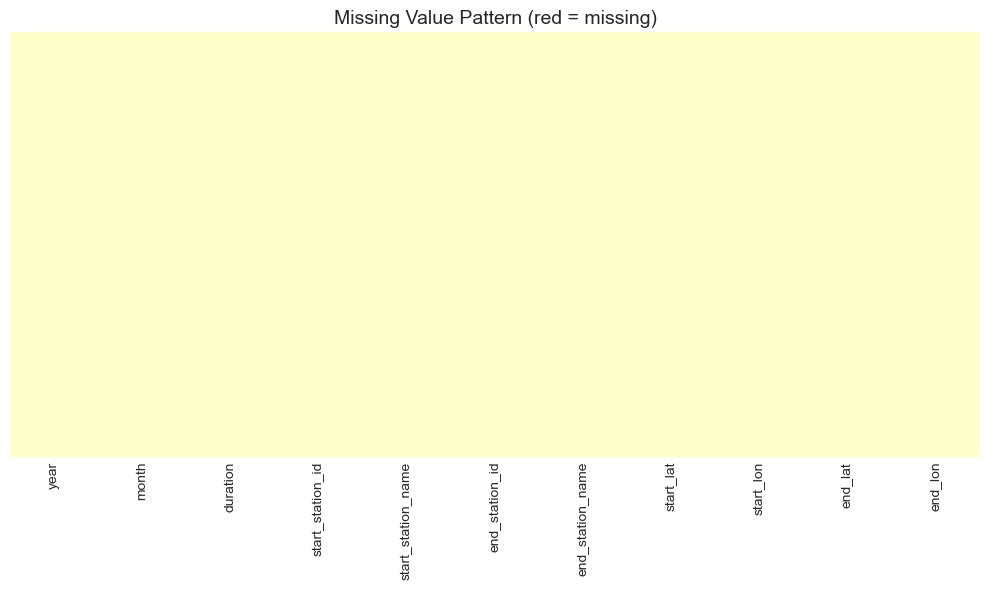

In [6]:
# =============================================================================
# Missing values per column
# =============================================================================
print("=== Missing values per column ===")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='YlOrRd', ax=ax)
ax.set_title('Missing Value Pattern (red = missing)', fontsize=14)
plt.tight_layout()
plt.show()

## Duration Distribution

In [7]:
# =============================================================================
# Filter to rows with valid duration for analysis
# =============================================================================
df_dur = df.dropna(subset=['duration']).copy()
df_dur['duration_min'] = df_dur['duration'] / 60
print(f"Trips with valid duration: {len(df_dur):,}")
print(f"Duration range: {df_dur['duration'].min():.0f}s - {df_dur['duration'].max():.0f}s")

Trips with valid duration: 10,034,294
Duration range: 61s - 8685730s


In [8]:
# =============================================================================
# Outlier detection: duration (box plot and IQR)
# =============================================================================
Q1 = df_dur['duration_min'].quantile(0.25)
Q3 = df_dur['duration_min'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df_dur[(df_dur['duration_min'] < lower) | (df_dur['duration_min'] > upper)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(range(len(df_dur)), df_dur['duration_min'], alpha=0.3, s=5, c=COLORS[0])
axes[0].set_xlabel('Observation Index')
axes[0].set_ylabel('Duration (minutes)')
axes[0].set_title('Trip Duration: All Observations')

df_dur.boxplot(column='duration_min', ax=axes[1], showfliers=False)
axes[1].set_ylim(0, min(upper * 1.1, 60))
axes[1].set_title('Box Plot of Trip Duration (capped for visibility)')
axes[1].set_ylabel('Duration (minutes)')
plt.tight_layout()
save_figure(fig, "eda_outlier_duration", prepared_dir)
plt.close(fig)
print(f"IQR = {IQR:.1f} min, Fences: [{lower:.1f}, {upper:.1f}] min")
print(f"Potential outliers: {len(outliers):,} ({100*len(outliers)/len(df_dur):.1f}%)")

IQR = 8.3 min, Fences: [-6.7, 26.6] min
Potential outliers: 765,527 (7.6%)


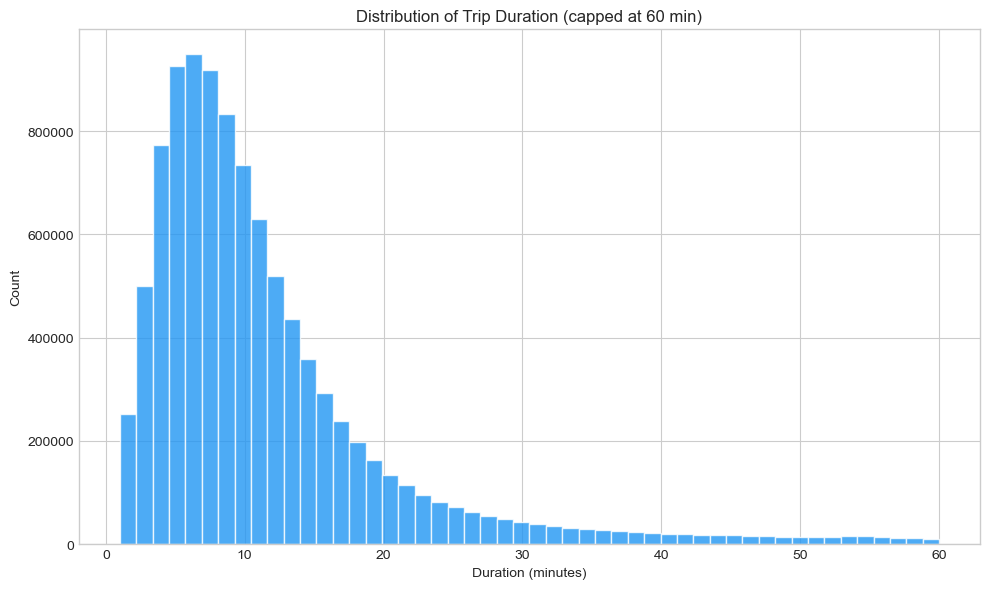

Mean: 12.9 min
Median: 9.1 min
Std: 65.6 min


In [9]:
# =============================================================================
# Histogram of trip duration (excluding extreme outliers for visibility)
# =============================================================================
dur_capped = df_dur[df_dur['duration_min'] <= 60]['duration_min']
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.hist(dur_capped, bins=50, color=COLORS[0], edgecolor='white', alpha=0.8)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Trip Duration (capped at 60 min)')
plt.tight_layout()
plt.show()

print(f"Mean: {df_dur['duration_min'].mean():.1f} min")
print(f"Median: {df_dur['duration_min'].median():.1f} min")
print(f"Std: {df_dur['duration_min'].std():.1f} min")

## Temporal Patterns

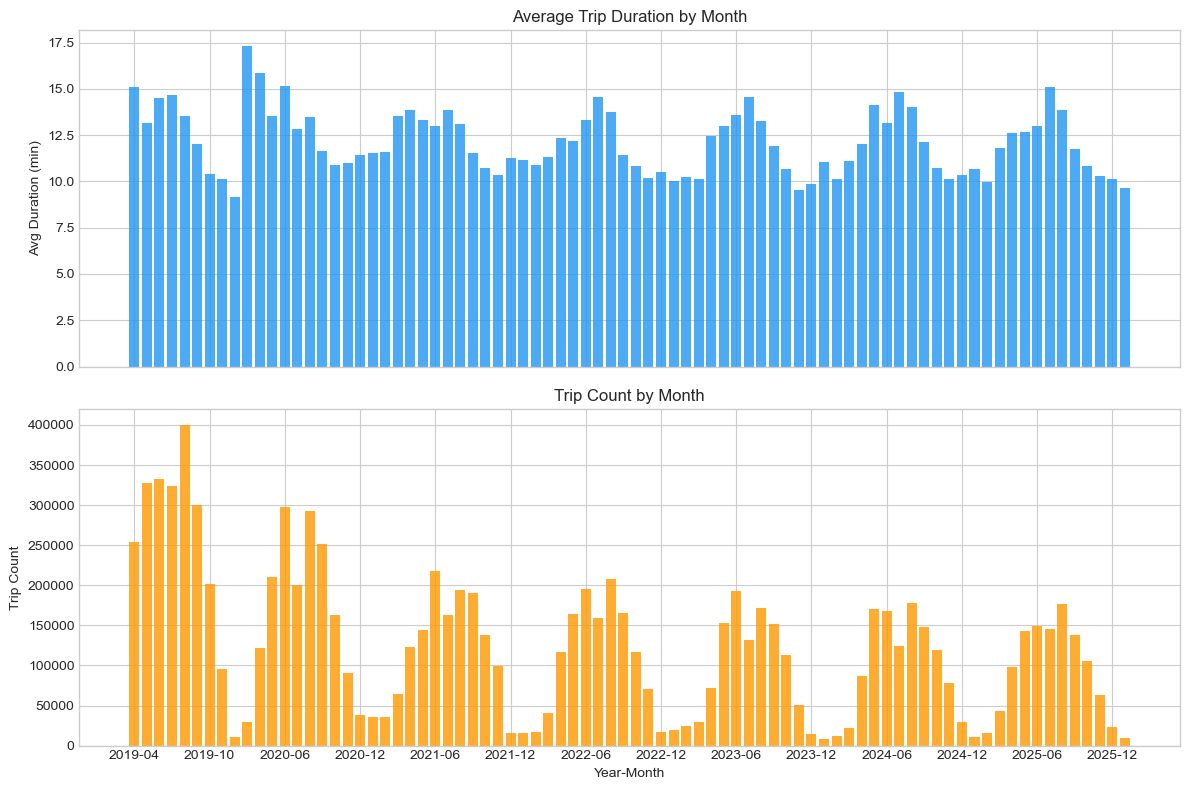

In [10]:
# =============================================================================
# Average duration and trip count by month
# =============================================================================
by_month = df_dur.groupby(['year', 'month']).agg(
    avg_duration_min=('duration_min', 'mean'),
    trip_count=('duration', 'count')
).reset_index()
by_month['year_month'] = by_month['year'].astype(str) + '-' + by_month['month'].astype(str).str.zfill(2)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].bar(range(len(by_month)), by_month['avg_duration_min'], color=COLORS[0], alpha=0.8)
axes[0].set_ylabel('Avg Duration (min)')
axes[0].set_title('Average Trip Duration by Month')
axes[0].set_xticks(range(0, len(by_month), 6))
axes[0].set_xticklabels(by_month['year_month'].iloc[::6])

axes[1].bar(range(len(by_month)), by_month['trip_count'], color=COLORS[1], alpha=0.8)
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Trip Count')
axes[1].set_title('Trip Count by Month')
axes[1].set_xticks(range(0, len(by_month), 6))
axes[1].set_xticklabels(by_month['year_month'].iloc[::6])
plt.tight_layout()
plt.show()

## Categorical Exploration

=== Top 10 start stations ===
start_station_name
Alexander Kiellands Plass    132928
Ringnes Park                 124875
Olaf Ryes plass              120790
Helga Helgesens plass        110901
Torggata                     100788
Tjuvholmen                   100314
Sukkerbiten                   99409
Bislett Stadion               99351
Tøyen skole                   98594
Kirkeristen                   88352
Name: count, dtype: int64


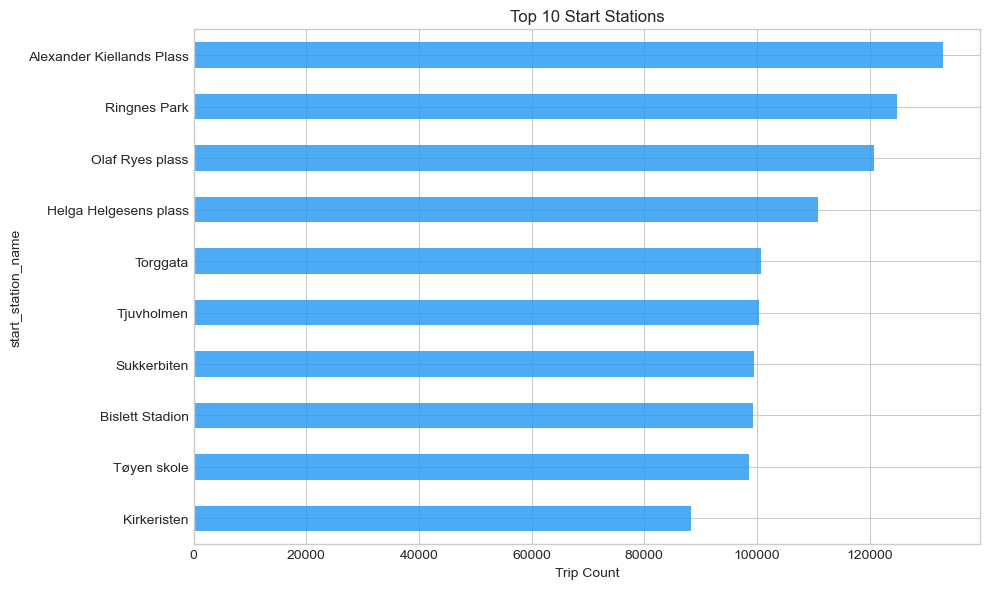

In [11]:
# =============================================================================
# Top start stations by trip count
# =============================================================================
top_start = df_dur['start_station_name'].value_counts().head(10)
print("=== Top 10 start stations ===")
print(top_start)

fig, ax = plt.subplots(figsize=(10, 6))
top_start.plot(kind='barh', ax=ax, color=COLORS[0], alpha=0.8)
ax.set_xlabel('Trip Count')
ax.set_title('Top 10 Start Stations')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Statistical Moments & Write Output

In [12]:
# =============================================================================
# Four statistical moments of trip duration
# =============================================================================
dur = df_dur['duration_min']
print("=== Four Moments of Trip Duration (minutes) ===")
print(f"Mean:     {dur.mean():.2f}")
print(f"Variance: {dur.var():.2f}")
print(f"Skewness: {dur.skew():.2f}")
print(f"Kurtosis: {dur.kurtosis():.2f}")

=== Four Moments of Trip Duration (minutes) ===
Mean:     12.86
Variance: 4299.42
Skewness: 1158.58
Kurtosis: 2387060.75


In [13]:
# =============================================================================
# Write EDA summary to prepared-data with execution metadata
# =============================================================================
null_counts_per_column = {k: int(v) for k, v in df.isnull().sum().to_dict().items()}
station_counts = df_dur["start_station_name"].value_counts().sort_values(ascending=False)
station_trip_counts = [{"station_name": str(name), "trip_count": int(count)} for name, count in station_counts.items()]
dur_capped = df_dur["duration_min"].clip(upper=60)
hist, _ = np.histogram(dur_capped, bins=list(range(61)))
duration_distribution = [{"bin_min": i, "count": int(c)} for i, c in enumerate(hist)]

# Dataset info from df.info() - structured for export
dataset_info = {
    "n_rows": int(df.shape[0]),
    "n_columns": int(df.shape[1]),
    "columns": [{"name": str(c), "dtype": str(df[c].dtype), "non_null": int(df[c].notna().sum())} for c in df.columns],
    "memory_mb": round(df.memory_usage(deep=True).sum() / (1024**2), 6),
}

# Summary stats from df.describe() - numeric columns only
desc = df.describe()
summary_stats = {}

for col in desc.columns:
    summary_stats[col] = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) for k, v in desc[col].items()}

eda_summary = {
    "n_trips": len(df_dur),
    "n_months": len(by_month),
    "dataset_info": dataset_info,
    "summary_stats": summary_stats,
    "duration_stats": {
        "mean_min": float(dur.mean()),
        "median_min": float(dur.median()),
        "std_min": float(dur.std()),
        "skewness": float(dur.skew()),
        "kurtosis": float(dur.kurtosis()),
    },
    "avg_by_month": [{"year": int(r["year"]), "month": int(r["month"]), "avg_duration_min": float(r["avg_duration_min"]), "trip_count": int(r["trip_count"])} for _, r in by_month[['year', 'month', 'avg_duration_min', 'trip_count']].iterrows()],
    "null_counts_per_column": null_counts_per_column,
    "station_trip_counts": station_trip_counts,
    "duration_distribution": duration_distribution,
}

write_with_execution_metadata(out_path, eda_summary, _pipeline_start_time)
print(f"Wrote EDA summary to {out_path}")

Wrote EDA summary to c:\Users\Nicol\Desktop\INF252-Course-Project\prepared-data\eda_summary_stats.json
